# 06. Mask R-CNN.

Сегодня рассмотрим семейство двух стадийных детекторов `R-CNN`, а особенно `Mask R-CNN`.  

C помощью `Mask R-CNN` можно решать задачи детектирования и сегметации объектов (object detection, instance segmentation).

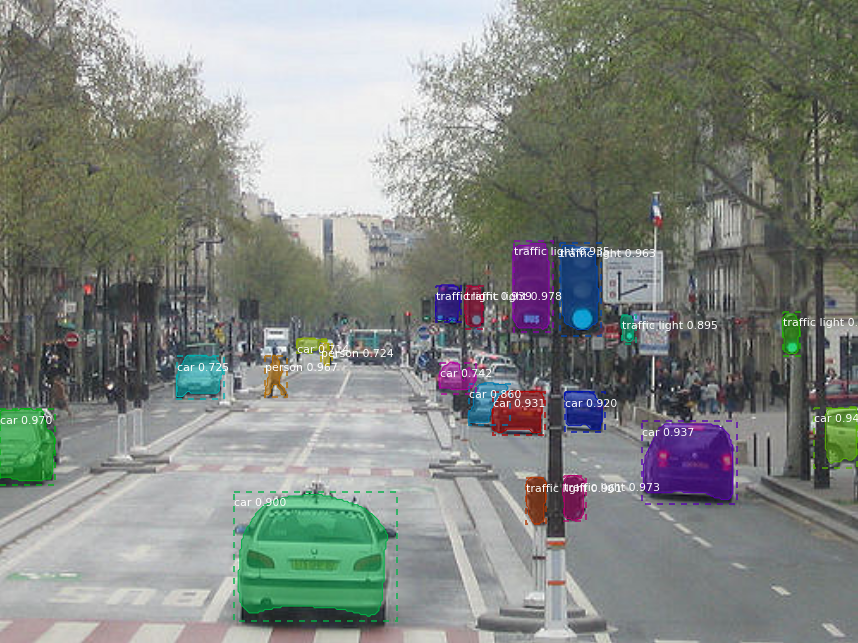

## **6.1 История R-CNN**

`Mask R-CNN` это сестра известных вам моделек:
- [`R-CNN (2014`)](http://islab.ulsan.ac.kr/files/announcement/513/rcnn_pami.pdf)
- [`Fast R-CNN (2015)`](https://arxiv.org/pdf/1504.08083.pdf)
- [`Faster R-CNN (2016)`](https://arxiv.org/pdf/1506.01497.pdf)

Разберем ещё раз как совершенствовался подход от архитектуры к архитектуре.

### **6.1.1 R-CNN**

**Идеи**: 
- случайно сгенерируем регионы (2000 штук, разных размеров и форм) где МОГУТ быть объекты (их зовем `RoI - regions of interest`), 
- вырежем части изображения, которые находятся внутри каждого из регионов, приведем изображения к одному размеру и подадим в `CNN` (`AlexNet` например) для получения дескриптора этого региона (4096 фич), 
- для всех векторов-дескрипторов применим `binary SVM` для классификации, для каждого класса своя модель классификации.
- для боксов используем регрессию, чтобы уточнить локализацию `positive examples` - тех, что приматчились по `IoU > 0.3` к `gt` боксам (тут также используются векторы-дескрипторы)
- отфильтруем слишком пересекающиеся боксы вокруг одного и того же объекта (`NMS, Non-Maximum Supression`)

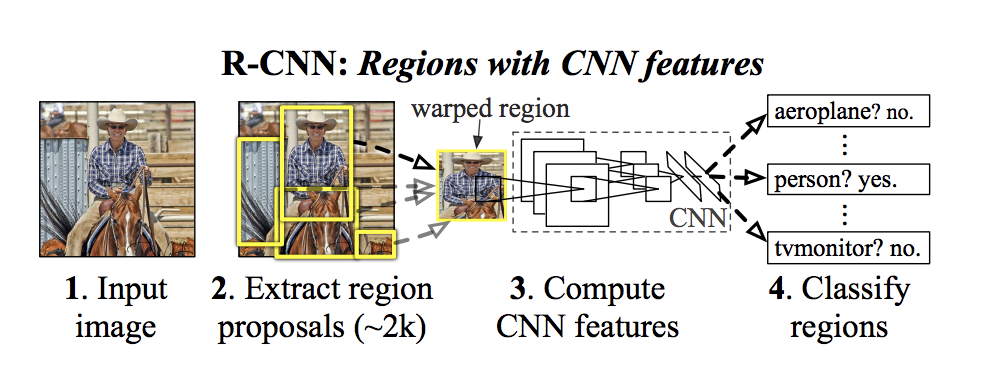

В случае `R-CNN` для выбора регионов используется процедура [`Selective Search`](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf). Это итеративная кластеризационная  процедура: сперва инициализируются маленькие регионы, а далее производит их иерархичное объединение (по цветовым/текстурным/similarity метрикам), пока не объединит всё изображение в регион. В `R-CNN` `Selective Search` передает ~2000 регионов.

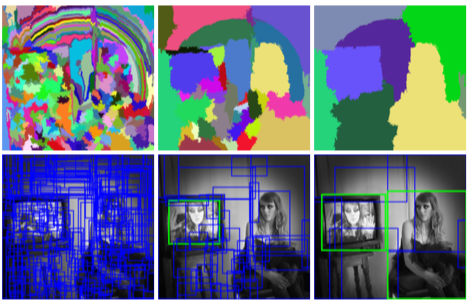

**NMS?**

`NMS (non-maximum suppression)` - процедура, необходимая для детектирования. Представьте, что мы нашли вокруг одного и того же объекта несколько боксов, смещенных друг относительно друга, а нужен там только один, ведь целевой объект один. 

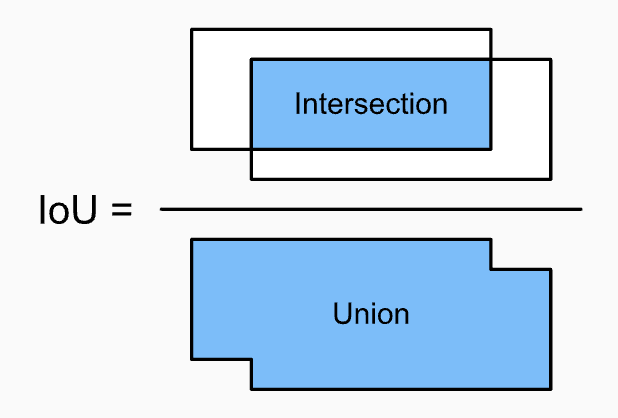

Процедура работает итеративно:
 1. Берем детекцию с наибольшим `score`  - `Best` и сразу кладем в финальный список (она там первая)
 2. Рассчитываем `IoU Best` со всеми остальными детекциями которые пока в списке претендентов. Если для какой то детекции `P` `IoU_Best_P > threshold`, то выкидываем `P` насовсем. Так жестоко поступаем со всеми детекциями!
 3. Если в первоначальном списке что то осталось, снова берем `Best` детекцию (с наибольшим `score`) и кладем в финальный список 
 4. `Best` детекцию сравниваем с оставшимися детекциями из списка претендентов (считаем IoU со всеми и выкидываем те, что выше порога)
 5. Повторяем пока список претендентов не будет пуст

Такая процедура называется `hard-NMS`. Понятно что у неё есть недостаток - если объекты различны, но слишком близки не получится подобрать оптимально `threshold` на `IoU`, чтобы не оставлять и не выкидывать лишнее. 

Есть вариант использовать [`soft-NMS`](https://arxiv.org/pdf/1704.04503.pdf), когда мы не выкидываем сильно совпадающие детектирования, а понижаем их `scores` пропорционально `IoU`, то есть они понижают позицию в списке претендентов.

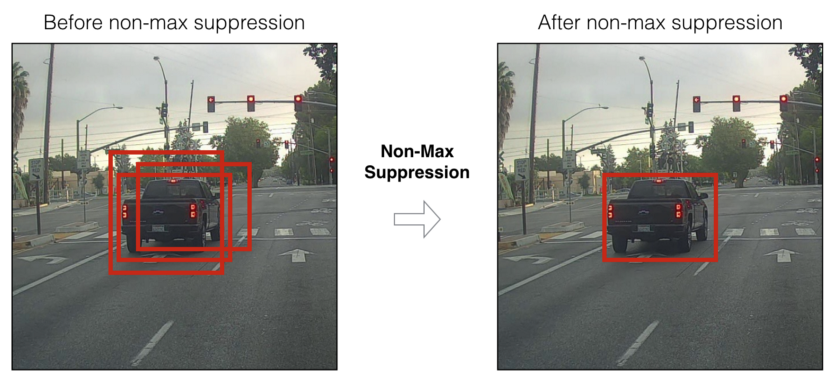

**Недостатки**:
 - у системы много компонент - модель `CNN`, модели `SVM` учи, модель регрессию. Сложный процесс
 - На инференсе не лучше - `selective search` медленный! для каждого из 2000 регинов запускать `CNN` и проделывать все трюки медленно!

В оригинальной статье приводятся замеры - **10 to 45 seconds per image on a GPU** (!!!) в зависимости от сложности CNN для дескрипторов. 

Это никуда не годится, что и авторы понимали, поэтому довольно скоро они представили....

### **6.1.2 Fast R-CNN**

**Идеи**:
 - Избавимся от кучи отдельных компонент (`CNN/ SVM/ Regression`), пусть **всё делает сетка** с несколькими выходами! а учить мы её сможем `end2end` (loss состоит их 2х частей)
 - Не будем запускать на регионах сеть 2000 раз (!!!!) а будем подавать на вход мощной сетки (`VGG16`) изображение целиком **1 раз**, получать `feature map`, как-то проецировать на неё первоначальные регионы и получать признаковые представления для каждого `RoI` сразу.

Скорость `Fast R-CNN` в **~9 раз** выше чем у `R-CNN` на обучении и **>200 раз** быстрее на инференсе.  

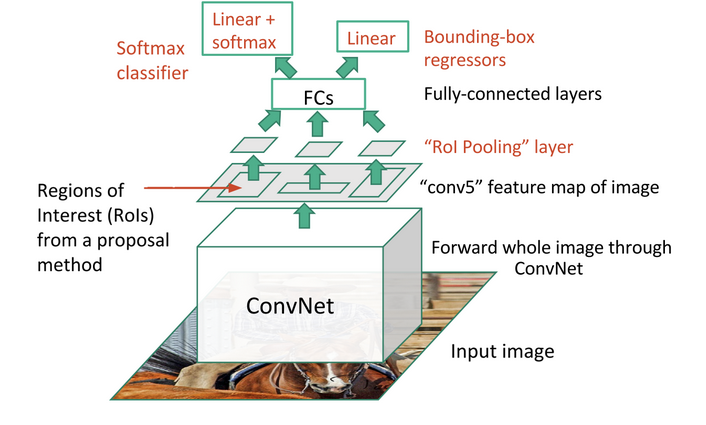

Отдельно обратим внимание на **`RoI pooling`**. 

Сперва нам нужно спроецировать первоначальные `RoI` на `feature map`, которую мы получили на выходе `backbone`. 

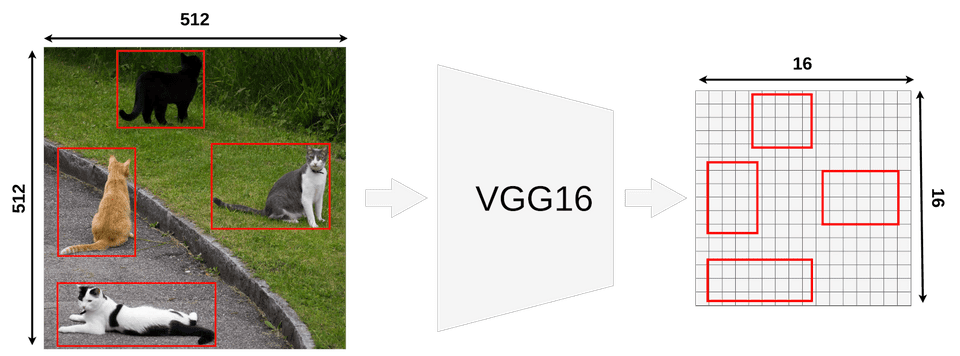

Для `VGG16` нам надо бы все размеры `RoI` именьшить в 32 раза и уложить на новую сетку. 

Скорее всего спроецированный `RoI` не будет ложиться идеально по нашим блокам `feature map`. Ну ничего, округлим до меньшего.

На данном рисунке мы выкинем и не будем учитывать дальше в пулинге синюю зону, а зеленую и кусочек голубой наоборот добавим.

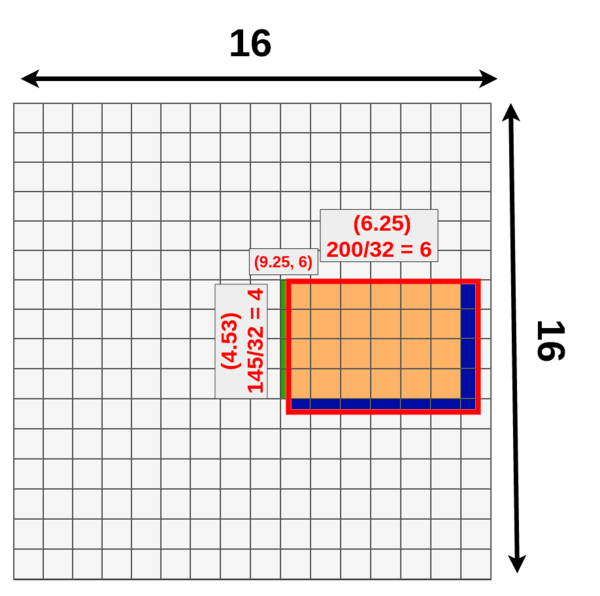

Мы спроецировали регионы в признаковое пространство, но они разного размера, а дескрипторы для них надо получить одинаковые (у нас дальше `fc` слои, они по-другому не умеют), поэтому используется `RoI pooling`.

Пусть нам надо для региона на выходе получить выход размера `2*2`, так мы берем да делим наш регион на 2 секции по вертикали и на 2 по горизонтали. В полученных областях делаем привычный выбор максимума - и готово.

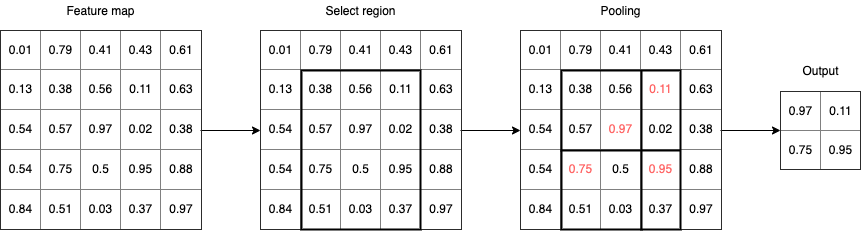

Почитайте ещё раз про `RoI` и `RoI pooling` [здесь](https://towardsdatascience.com/region-of-interest-pooling-f7c637f409af), это полезно. 

Что в итоге по `Fast R-CNN`? Скорость увеличили (`~2 seconds per frame`), точность тоже немножко подняли (если использовать мощную `CNN`).

А что же дальше?

### **6.1.3 Faster R-CNN**

**Идеи**:
- `Selective Search` всё ещё отстой, давайте и его заменим сеткой (`RPN - Region Proposal Net`)
- А всё остальное норм -  `Fast R-CNN`, которая использует картинку и `RoI` и работает как классификатор и регрессор, оставляем

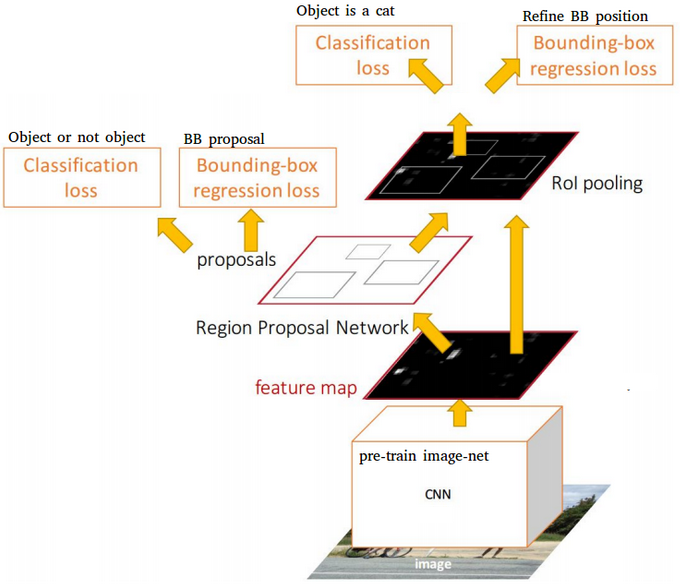

**Что происходит в RPN?**
 - Взяли картинку и прогнали через свертки - получили `feature maps`
 - На этих `feature maps` и будем учиться искать `RoI`! А когда получим боксы, будем их же использовать в сетке классификаторе-регрессоре.
 - Выберем `k` якорей - базовые формы `bbox`-ов, которые будем искать и дальше уточнять регрессором  
 - для каждой точки на `feature map` фиксируем `k` заготовок для будущих боксов - якорей (в статье их 9) с центром в ней (для `feature map` `H*W*C` получим `H*W*k` якорей, по краям `feature map` они просто обрезаются), для каждого их них далее будем получать вероятности содержания объектов и уточнения расположения с помощью регрессии
 - пробегаем сверткой по `feature map` и получаем новое представление, а затем на верх навешиваем `fc` слои для классификации и регрессии (здесь каждый нейрон в `fc` слоях отвечает за какой-то свой заранее установленный якорь)
 - Берем `6k` лучших заготовок (где вероятнее всего объекты), делаем отсев по `NMS` 
 - Выжившие регрессированные боксы отправляем дальше - на `RoI Pooling` по `feature maps` c 1 шага, а также на финальную классификацию и регрессию. Делаем внутриклассово ещё отсев по `NMS`

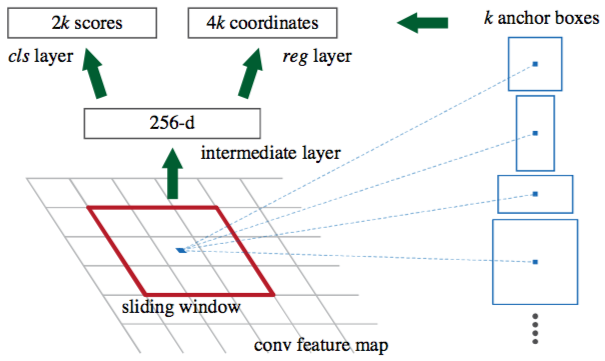

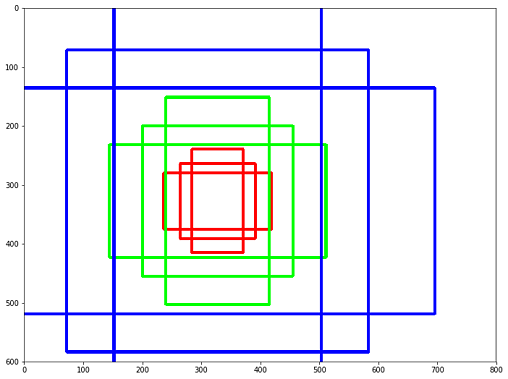

**Что неприятно?**

Обучается два отдельных модуля: сперва `RPN`, потом `Fast R-CNN`, снова `RPN` на основе обновленных `feature maps`, и опять `Fast R-CNN`.

В общем, `two-stage` детекторы неприяты в обучении (как и все системы из нескольких звеньев).

**Какие результаты?**

Здесь авторы достигли скорости `5 fps` (в `10` раз быстрее `Fast R-CNN`) на GPU, а в самой быстрой модификации уже `17 fps` (скоро и `realtime`). И это всё ещё одна из самых популярных и точных моделей детектирования. 

Реализация `Faster R-CNN` в нескольких вариантах есть в [`torchvision.models`](https://pytorch.org/vision/stable/models.html#id35).

На основе нее и создана наша сегодняшняя героиня - **Mask R-CNN**.

## **6.2 Хочу всё сразу**

[`Mask R-CNN`](https://arxiv.org/pdf/1703.06870.pdf) способна решать две задачи - это и детектирование объектов, и получение маски для каждого задетектированного объекта (instance segmentation).

**Идея:**

Да просто возьмем и для полученных детекций не только предскажем класс и уточним координаты, а ещё накидаем конволюций не снижаюших размерность и получим бинарные маски (объект/фон) для внутренностей боксов.

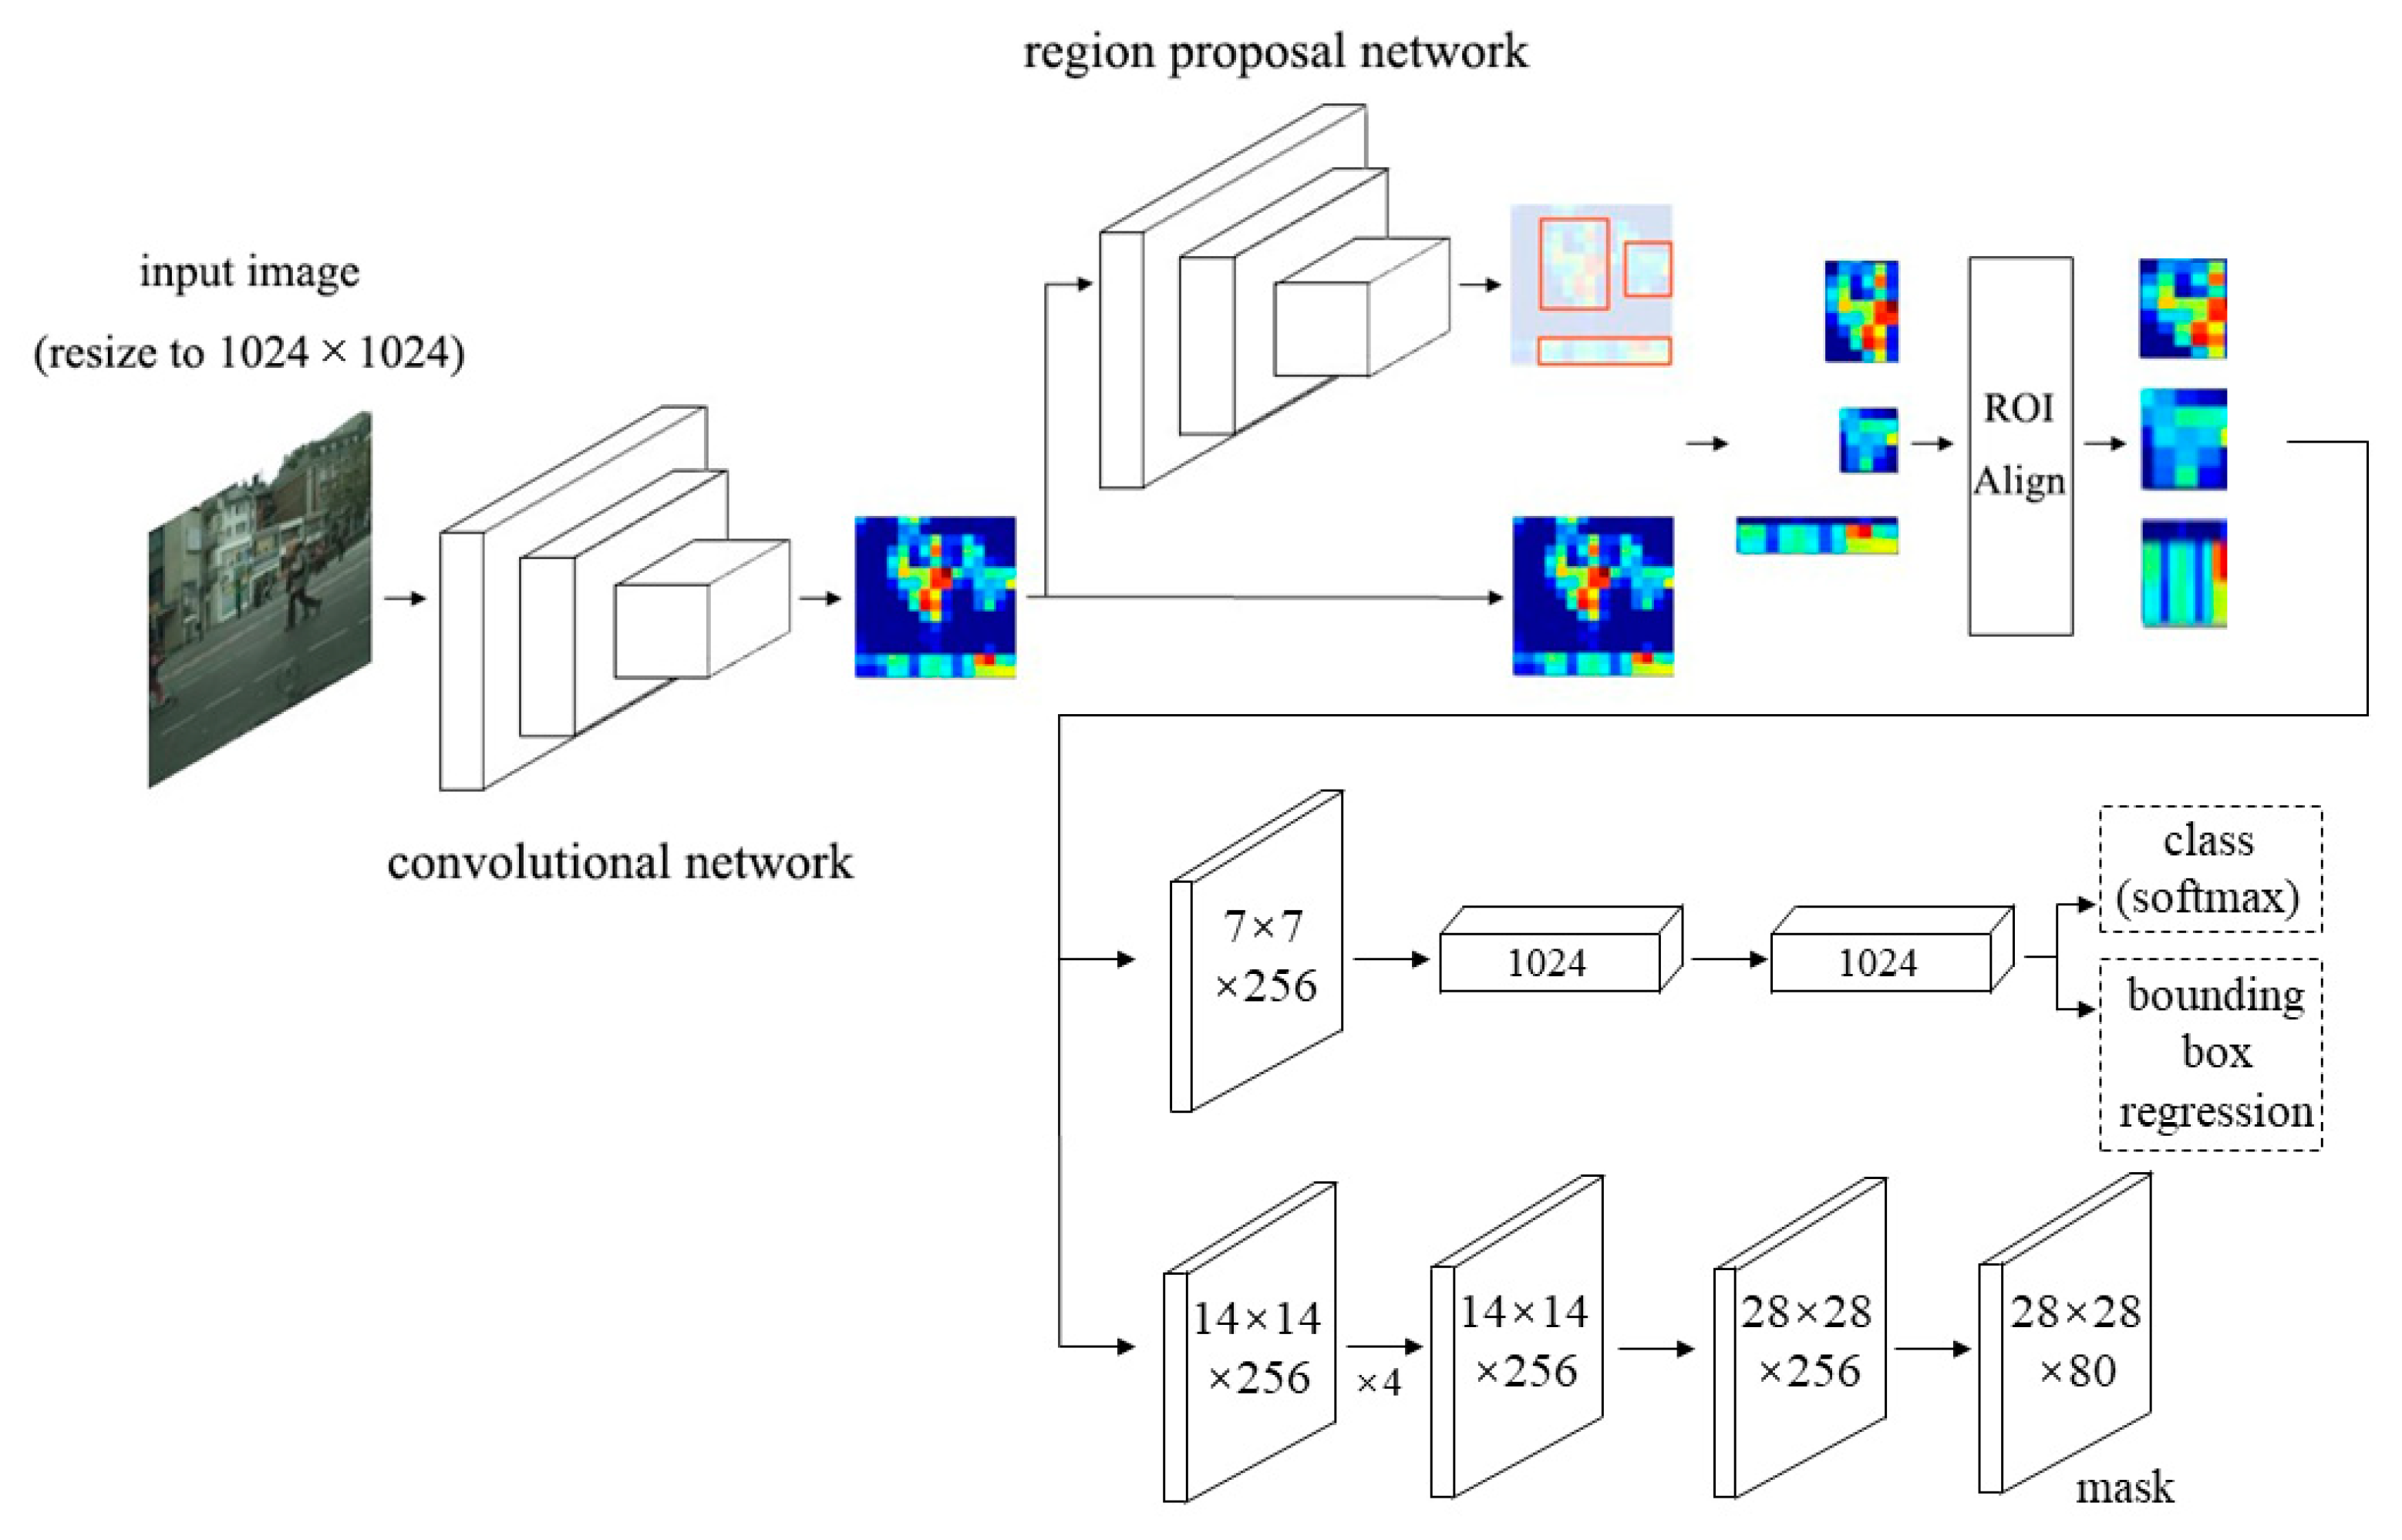

Что ещё изменилось по сравнению с `Faster R-CNN` кроме новой головы?

**RoI Pool заменили на RoI Align.**

Как мы помним, при `RoI pooling` при некратных размерах `RoI`, мы теряли данные, а далее резали как придется, что было приемлемо для `bbox`-ов (ну скривим бокс немного, не очень страшно), но стало причиной проблем, когда авторы начали делать попиксельную сегментацию. 

**Что делаем?** Не будем отрезать края, если `RoI` ложится не точно по блокам `feature map`, не будем внутри получившейся зоны резать на кривые области. Накинем на зону ровную сетку, бнутри блока сетки берем 4 точки (ровно делят бокс на ещё на одну сетку `3*3`), для каждой из них используя билинейную интерполяцию считаем значение на основании ближайших к ней клеток `feature map`. Далее из этих 4 значений выбираем максимальное - фактически делаем `MaxPooling` и получаем элемент финальной сетки. Все то же самое делаем для каждого канала, ведь `Pooling` не снижает их размерность.

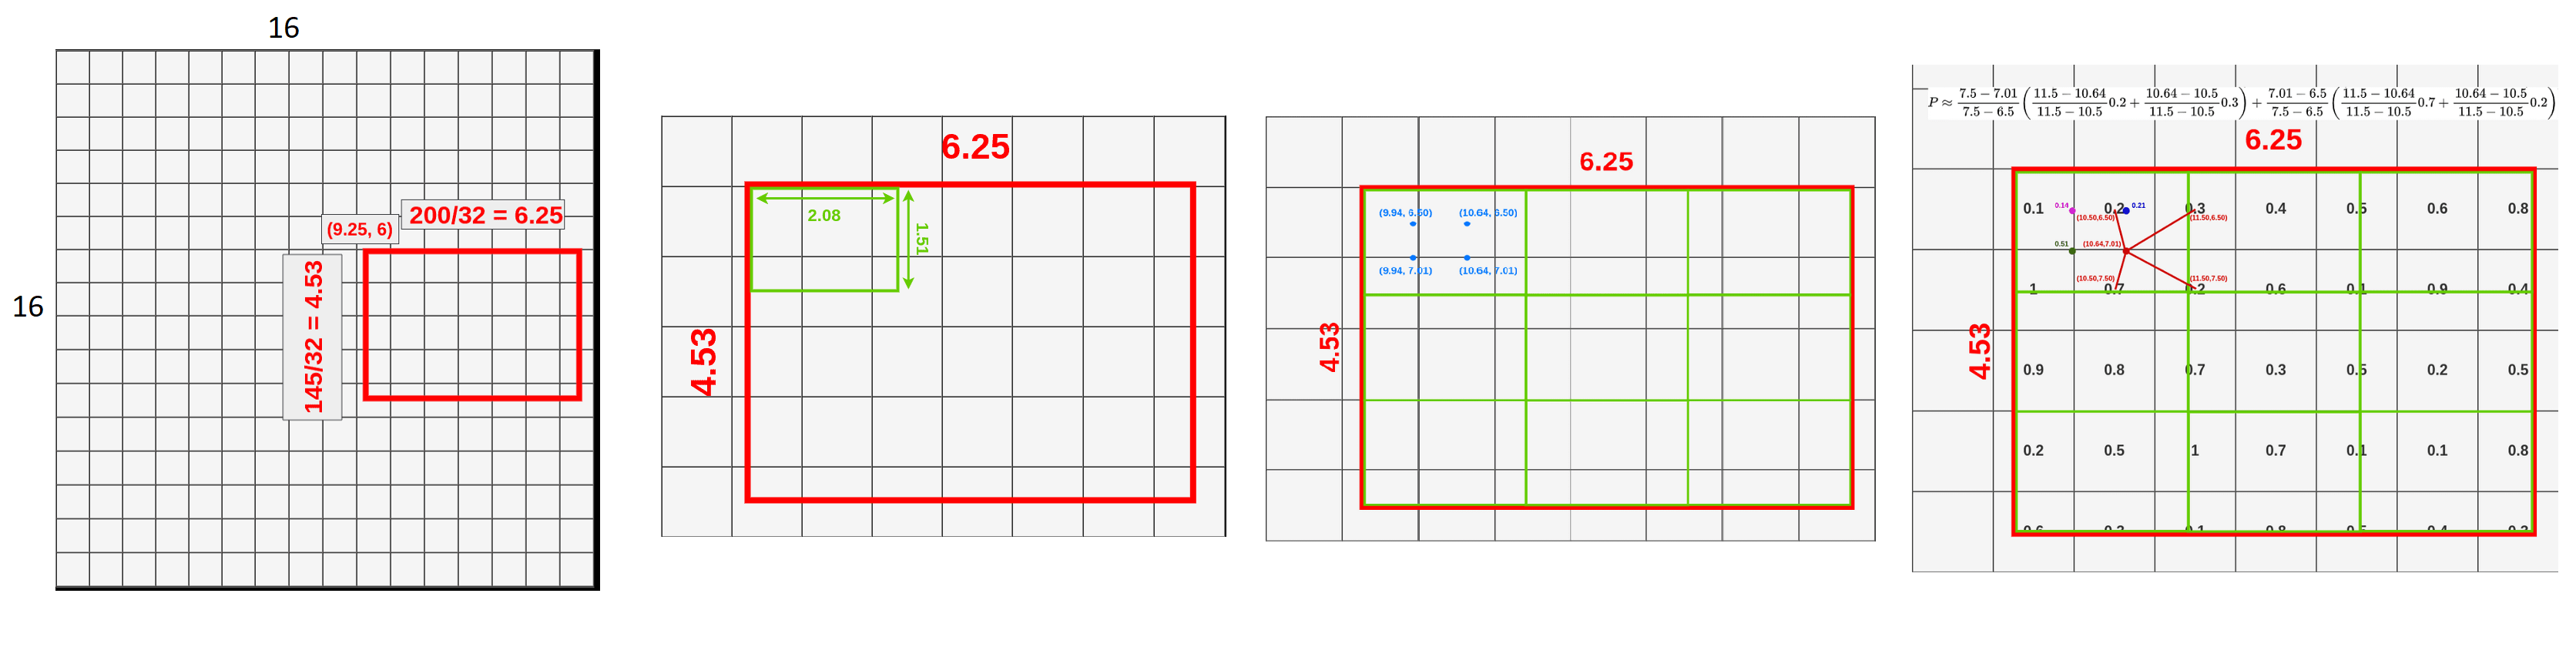

Посмотреть гифку [тут](https://miro.medium.com/max/839/0*7WFmQBxoOCPu2BDJ.gif). Подробная статья [тут](https://towardsdatascience.com/understanding-region-of-interest-part-2-roi-align-and-roi-warp-f795196fc193). 

Вот и всё, наслаждаемся точной сегментацией. Ещё и точность детектирования авторы подняли (засчет `RoIAlign`, а ещё ResNet50 в качестве BackBone network).

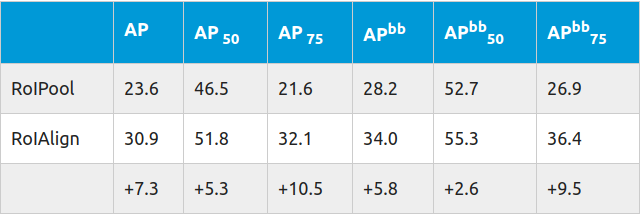

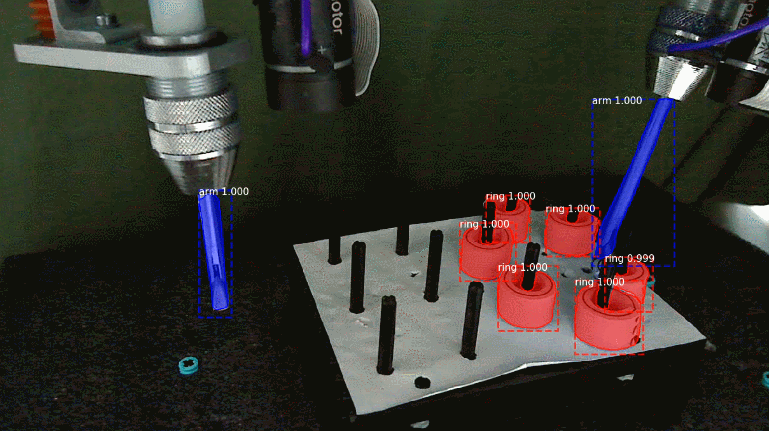

## **6.3 А что за точность у детекторов?**

Вопрос не такой простой, так как тут мы оцениваем два пункта - правильно ли мы предсказали класс объекта и как хорошо его локализовали.

Стандартнам метрика - **mean Average Precision** или `mAP`. Mean работает в задаче многоклассовой детекции - усредняя `AP` всех классов, таким образом делая их равноправными вне зависимости от размера.

**Как считаем AP для одного класса?**

Процедура такая: 
- если `IoU(det, gt) > threshold`, то эту детекцию записываем в положительные, так же проверяем все остальные детекции. Если к одному и тому же `gt` матчатся несколько детекций, берем только наибольшую по скору как положительную, остальные пытаются матчиться с другими `gt`, если не получится, то пишутся в отрицательные. Таким образом про все детекции мы поняли норм они или нет.
- ранжируем все эти детекции по `score` и начинаем для каждого ранга (числа просмотренных семплов) считать `Precision/Recall`.

Вот буквально так: (всего должно быть 5 истинных детекций)

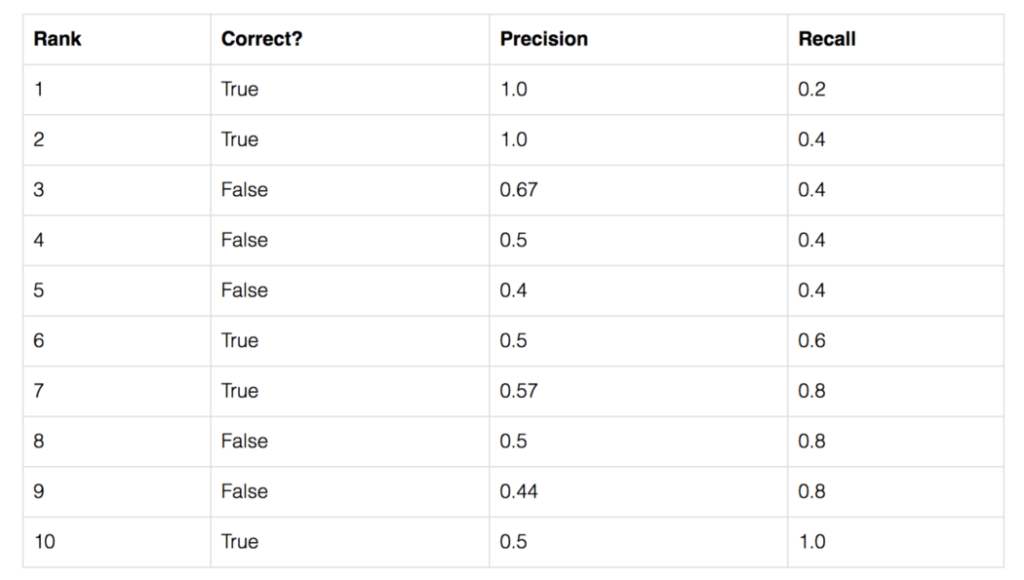

`Recall` будет расти пока мы движемся по списку, так как мы захватываем больше и больше позитивных примеров, `Precision` скачет.

Нарисуем кривую `precision-recall` (из 10 точек):

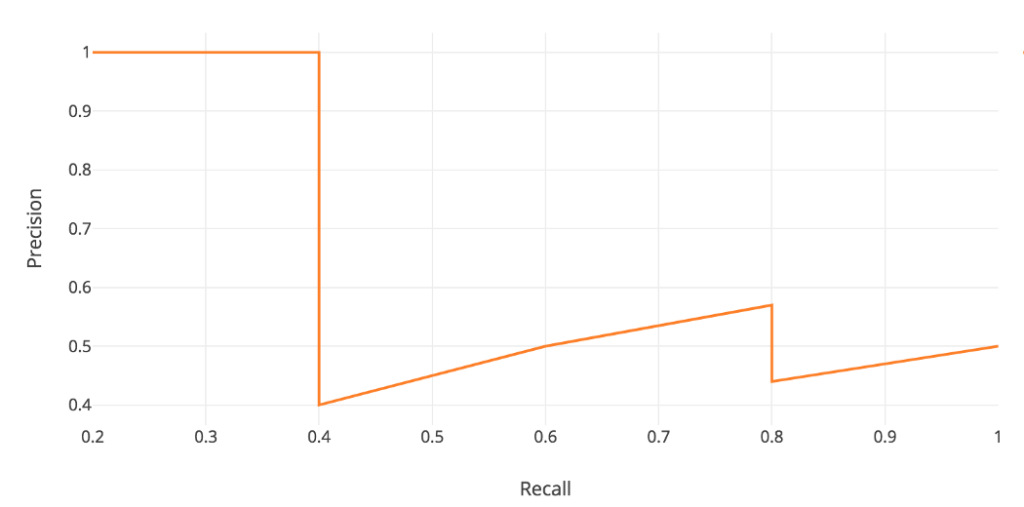

**Average Precision** - это площадь под такой кривой. Лежит она в диапазоне `[0, 1]`, как и сами `Precision/Recall`. 

Прежде чем считать `AP`, делается сглаживание зигзага, чтобы функция стала монотонно убывающей:

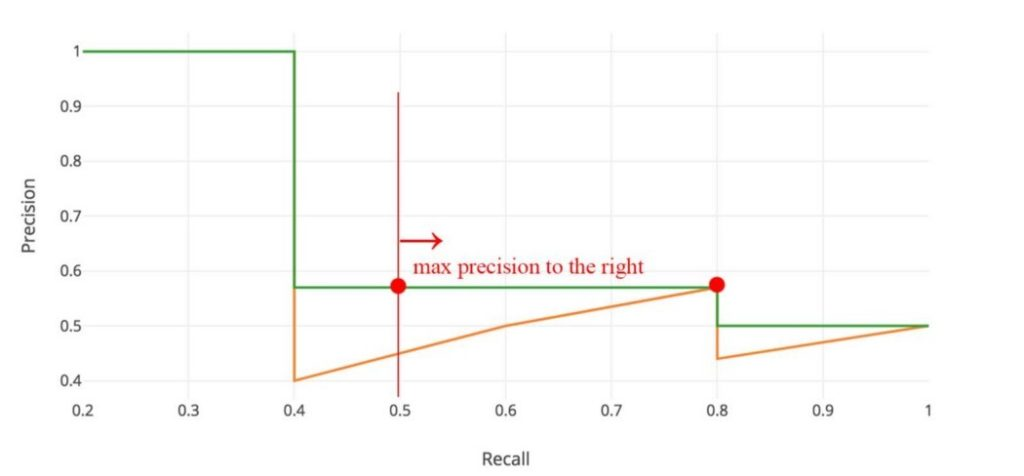

Вот под такой кривой уже несложно посчитать площадь.

А ещё почитать и посмотреть примеры можно [тут](https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2).

## **6.4 Программный код**

Для `Mask R-CNN` есть несколько известных открытых реализаций на `pytorch`: например [ссылка](https://github.com/multimodallearning/pytorch-mask-rcnn).

Но есть и модель в `torchvision`, который мы уже очень любим. А именно в [`models.detection`](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection). В последней версии количество доступных моделей там выросло с 2 до целых 5, ещё и с разными `backbones`. 

В `torchvision` есть только одна разновидность [`Mask R-CNN`](https://pytorch.org/vision/0.10/models.html#id41) - c `Resnet50`. Но вы можете собрать модель и со своим `Backbone`.

In [1]:
import cv2
import torch
import random
import json
import torchvision
import numpy as np

import colorsys
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours

from PIL import Image
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn as mask_rcnn

In [2]:
model = mask_rcnn(pretrained=True)
#model = model.cuda()
_ = model.eval()

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Реализации [`RoiAlign`](https://pytorch.org/vision/0.10/ops.html#torchvision.ops.MultiScaleRoIAlign), [`MaskRCNN`](https://pytorch.org/vision/0.10/_modules/torchvision/models/detection/mask_rcnn.html#maskrcnn_resnet50_fpn), [`FasterRCNN`](https://pytorch.org/vision/0.10/_modules/torchvision/models/detection/faster_rcnn.html#fasterrcnn_resnet50_fpn), [`Generalized RCNN`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py#L13), [`backbone ResNet50`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py#L51), [`FrozenBatchNorm`](https://github.com/pytorch/vision/blob/main/torchvision/ops/misc.py#L52) если интересно.

In [3]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [4]:
coco_labels = ["background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", 
               "traffic light", "fire hydrant", "street sign", "stop sign", "parking meter", "bench", "bird", "cat", 
               "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "hat", "backpack", 
               "umbrella", "shoe", "eye glasses", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", 
               "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", 
               "bottle", "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", 
               "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", 
               "bed", "mirror", "dining table", "window", "desk", "toilet", "door", "tv", "laptop", "mouse", "remote", 
               "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "blender", "book", 
               "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush", "hair brush"]

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
img_path = '1.jpg'
img = Image.open(img_path)

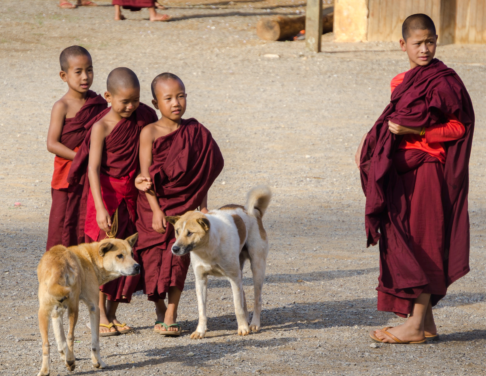

In [7]:
img

In [8]:
model = model.cuda()
output = model([transform(img).cuda()])

In [9]:
output[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [10]:
output[0]['scores'].shape

torch.Size([22])

In [11]:
output[0]['scores']

tensor([0.9989, 0.9976, 0.9976, 0.9968, 0.9950, 0.9914, 0.9854, 0.5129, 0.3675,
        0.2623, 0.1836, 0.1148, 0.1057, 0.1007, 0.0976, 0.0946, 0.0918, 0.0898,
        0.0788, 0.0740, 0.0534, 0.0518], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [12]:
#оборачиваем всё в функцию которая выбрет только боксы с score>th для нужной картинки
def get_prediction(img, th_conf, th_mask, transform):
  img = transform(img)
  pred = model([img.cuda()])
  
  pred_score = pred[0]['scores'].tolist()
  pred_class = pred[0]['labels'].tolist()
  pred_boxes = pred[0]['boxes'].tolist()
  pred_masks = (pred[0]['masks'] > th_mask).squeeze().detach().cpu().numpy() #маски зануляем ниже границы

  pred_t = [pred_score.index(x) for x in pred_score if x > th_conf][-1] #граница нужных скоров
  
  #обрезаем
  pred_masks = pred_masks[:pred_t+1]
  pred_boxes = np.array(pred_boxes[:pred_t+1])
  pred_class = np.array(pred_class[:pred_t+1])

  return pred_masks, pred_boxes, pred_class

In [13]:
masks, boxes, classes = get_prediction(img, th_conf=0.5, th_mask=0.4, transform=transform)

In [14]:
print(masks.shape)
print(boxes.shape)
print(classes)

(8, 376, 486)
(8, 4)
[ 1 18  1  1 18  1  1  1]


In [15]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [16]:
def visualize(image, boxes, masks, class_ids, class_names, scores=None, title="Segmented objects", figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True, colors=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[0] == class_ids.shape[0]

    #генерим случайные цвета для разных масок
    colors = colors or random_colors(N)

    _, ax = plt.subplots(1, figsize=figsize)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        #рисуем бокс
        x1, y1, x2, y2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7,
                                 linestyle="dashed", edgecolor=color, facecolor='none')
            ax.add_patch(p)

        #подпись класса
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption, color='w', size=11, backgroundcolor="none")

        #рисуем маску
        mask = masks[i, :, :]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

    ax.imshow(masked_image.astype(np.uint8))
    plt.show()

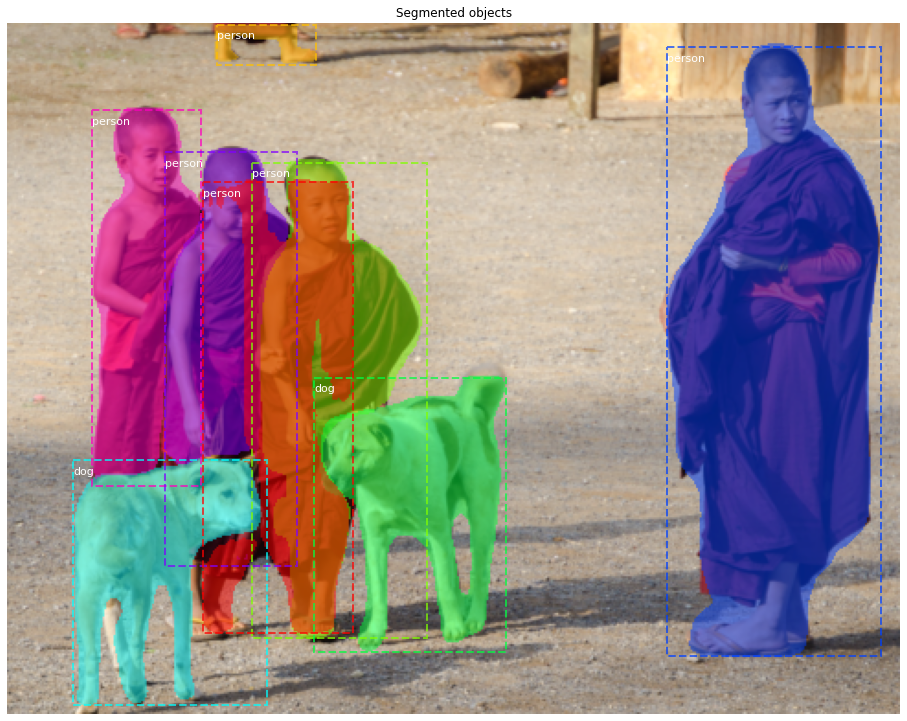

In [17]:
img = cv2.imread(img_path)
visualize(img[:, :, ::-1], boxes, masks, classes, coco_labels)

**Take-home thing.**

Разберитесь дома с официальным [туториалом](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) по `Mask R-CNN`.